In [1]:
import numpy as np
import pandas as pd

In [2]:
import glob
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

In [3]:
import sys
sys.path.insert(0, '/home/ubuntu/seongyoon/PI/Impedance')
from impedancecircuit.models.elements import R, C, L, CPE, p

In [4]:
cellname = '25C01'
# Cell name list
# 25C01
# 25C02
# 25C03
# 25C04
# 25C05
# 25C06
# 25C07
# 25C08
# 35C01
# 35C02
# 45C01
# 45C02

datapath = './data/Cavendish/'

filename = f'{datapath}EIS_state_V_{cellname}.txt'

data = pd.read_csv(filename, delimiter='\t')
data.columns = data.columns.str.strip()

cycle = 1
data_real = data[data['cycle number'] == cycle]['Re(Z)/Ohm'].values
data_imag = data[data['cycle number'] == cycle]['-Im(Z)/Ohm'].values
data_freq = data[data['cycle number'] == cycle]['freq/Hz'].values

impedance = np.concatenate([data_real, data_imag])

In [5]:
datapath = './data/Tongji/NCA battery/'

filename = sorted(glob.glob(f'{datapath}*.xlsx'))

sheet_names = pd.ExcelFile(filename[2]).sheet_names
# sheet = sheet_names[0]
sheet = sheet_names[3]
data = pd.read_excel(filename[2], sheet_name=sheet)
data_real = data["Data: Z'"].values
data_imag = -data["Data: Z''"].values
data_freq = data["Data: Frequency"].values

impedance = np.concatenate([data_real, data_imag])

In [6]:
datapath = './data/Tongji/NCM battery/'

filename = sorted(glob.glob(f'{datapath}*.xlsx'))

sheet_names = pd.ExcelFile(filename[0]).sheet_names
# sheet = sheet_names[0]
sheet = sheet_names[8]
data = pd.read_excel(filename[0], sheet_name=sheet)
data_real = data["Data: Z'"].values
data_imag = -data["Data: Z''"].values
data_freq = data["Data: Frequency"].values

impedance = np.concatenate([data_real, data_imag])

In [7]:
custom_initial_guess = np.ones(10)
custom_initial_guess[1] = np.log(min(data_real))
custom_initial_guess[0] = np.log(abs(data_imag[np.argmin(data_real)])/(2*np.pi*data_freq[np.argmin(data_real)]))

# custom_initial_guess[0] = 5.29e-7
# custom_initial_guess[1] = 0.35462
# custom_initial_guess[2] = 0.41355
# custom_initial_guess[3] = 0.037494
# custom_initial_guess[4] = 0.53428
# custom_initial_guess[5] = 0.27884
# custom_initial_guess[6] = 0.041607
# custom_initial_guess[7] = 0.85633
# custom_initial_guess[8] = 9.8113
# custom_initial_guess[9] = 0.64546

In [8]:
sigmoid_idx = np.zeros(len(custom_initial_guess), dtype=int)
sigmoid_idx[[4, 7, 9]] = 1

def sigmoid(x):
    # return 1./(1.+np.exp(-x))
    return np.where(x < 0, np.exp(x) / (1.+np.exp(x)), 1./(1.+np.exp(-x)))

def circuit_func(frequency, *parameters):
    parameters = np.array(parameters)
    parameters = np.where(sigmoid_idx,
                            sigmoid(parameters),
                            np.exp(parameters))
    # parameters[sigmoid_idx] = sigmoid(parameters[sigmoid_idx])
    # parameters[softplus_idx] = softplus(parameters[softplus_idx])
    # Temporarily fixed circuit
    z = L([parameters[0]], frequency) + \
        R([parameters[1]], frequency) + \
        p([R([parameters[2]], frequency),
            CPE([parameters[3], parameters[4]], frequency)]) + \
        p([R([parameters[5]], frequency),
            CPE([parameters[6], parameters[7]], frequency)]) + \
        CPE([parameters[8], parameters[9]], frequency)
    z_real = np.real(z)
    z_imag = -np.imag(z)
    return np.hstack([z_real, z_imag])

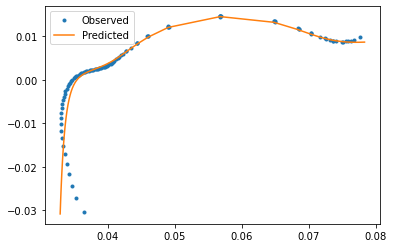

L     5.081251e-07
R0    1.586375e-02
R1    1.366816e-02
Q1    7.546791e-01
a1    1.270689e-01
R2    1.990537e-02
Q2    8.201729e+00
a2    9.926615e-01
Q3    4.074445e+01
a3    1.643270e-01
dtype: float64

In [9]:
# parameters, _ = curve_fit(circuit_func, data_freq, impedance,
                        #   p0=custom_initial_guess, method='lm')#, factor=100, ftol=1e-6, xtol=1e-6)#, maxfev=10000)

results = least_squares(lambda x: np.hstack([circuit_func(data_freq, *x) - impedance, np.abs(impedance).mean()*0.01*x]), x0=custom_initial_guess, method='lm', x_scale='jac')
parameters = results.x

impedance_pred = circuit_func(data_freq, *parameters)

plt.plot(data_real, data_imag, '.', label='Observed')
plt.plot(impedance_pred[:len(impedance_pred)//2], impedance_pred[len(impedance_pred)//2:], '-', label='Predicted')
plt.legend()
plt.show()

pd.Series(np.where(sigmoid_idx,sigmoid(parameters),np.exp(parameters)), index=['L', 'R0', 'R1', 'Q1', 'a1', 'R2', 'Q2', 'a2', 'Q3', 'a3'])

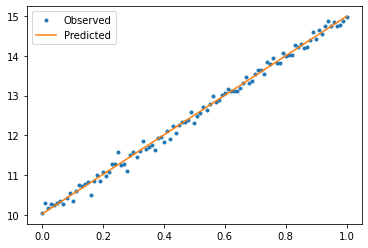

In [10]:
def test_func(x, *parameters):
    return parameters[0] + x*parameters[1]

xxx = np.linspace(0, 1, 101)
yyy = 10 + xxx*5 + np.random.randn(len(xxx))*0.1

results = least_squares(lambda p: test_func(xxx, *p) - yyy, x0=[5, 2], method='lm')

yyy_pred = test_func(xxx, *results.x)

plt.plot(xxx, yyy, '.', label='Observed')
plt.plot(xxx, yyy_pred, '-', label='Predicted')
plt.legend()
plt.show()